# Walmart time series forecasting

## Libraries

In [83]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor

## Exploratory Data Analysis (EDA)

Questions for EDA:
- Why do we have as many as 3 files for training? What do they contain?
- What are the features? What are their types and values?
- Are there any missing values? Are they missing for temporal or static data?

In [2]:
stores = pd.read_csv("./data/walmart/stores.csv")
train = pd.read_csv("./data/walmart/train.csv")
test = pd.read_csv("./data/walmart/test.csv")
features = pd.read_csv("./data/walmart/features.csv")

### Stores

`stores` - anonymized information about the 45 stores, indicating the type and size of store:
- `Store` - number of store, range 1-45
- `Type` - "A", "B" or "C"
- `Size` - number of products available in the particular store

In [3]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [5]:
stores.isnull().sum() * 100 / len(stores)

Store    0.0
Type     0.0
Size     0.0
dtype: float64

### Train

`train` - historical training data, covering dates from 2010-02-05 to 2012-11-01 with weekly frequency:
- `Store` - the store number, range 1-45
- `Dept` - the department number, range 1-99
- `Date` - the week
- `Weekly_Sales` -  sales for the given department in the given store, forecasting target
- `IsHoliday` - whether the week is a special holiday week: Super Bowl, Labor Day, Thanksgiving or Christmas

In [6]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [8]:
train.isnull().sum() * 100 / len(train)

Store           0.0
Dept            0.0
Date            0.0
Weekly_Sales    0.0
IsHoliday       0.0
dtype: float64

### Test

`test` - target test data. The same attributes as the `train` table.

In [9]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [11]:
test.isnull().sum() * 100 / len(test)

Store        0.0
Dept         0.0
Date         0.0
IsHoliday    0.0
dtype: float64

### Features

`features` - additional data related to the store, department, and regional activity for the given dates:
- `Store` - the store number
- `Date` - the week
- `Temperature` - average temperature in the region
- `Fuel_Price` - cost of fuel in the region
- `MarkDown1-5` - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- `CPI` - the consumer price index
- `Unemployment` - the unemployment rate
- `IsHoliday` - whether the week is a special holiday week

Holiday weeks:

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [12]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [13]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [14]:
(features.isnull().sum() * 100 / len(features)).round()

Store            0.0
Date             0.0
Temperature      0.0
Fuel_Price       0.0
MarkDown1       51.0
MarkDown2       64.0
MarkDown3       56.0
MarkDown4       58.0
MarkDown5       51.0
CPI              7.0
Unemployment     7.0
IsHoliday        0.0
dtype: float64

In [15]:
features.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


### EDA - takeaways

1. `stores` contains static data about each shop, `train` and `features` both contain temporal data.
2. There are no missing values in `stores`, `train` and `test`.
3. `features` contains missing values in multiple columns, often a lot (over 50%).
4. To get all data about each store, merging the `stores`, `train` and `features` will be required

Before visualizing data, I will perform the last step to prepare the entire training data in one dataframe.

## Data manipulation

Merging the `stores`, `train` and `features` tables:

In [16]:
# do not use "inner" to avoid losing any data
df = pd.merge(train, features, how="left")
df = pd.merge(df, stores, how="left")
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


The following columns need data type changes:
- `Date` - change to datetime, make index
- `Store` - change to categorical
- `Dept` - change to categorical
- `Type` - change to categorical

In [18]:
df["Date"] = pd.to_datetime(df["Date"])
df["Store"] = pd.Categorical(df["Store"])
df["Dept"] = pd.Categorical(df["Dept"])
df["Type"] = pd.Categorical(df["Type"])

df.set_index(keys="Date", inplace=True)
df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
Date,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2010-02-12,1,1,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2010-02-19,1,1,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
2010-02-26,1,1,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
2010-03-05,1,1,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [19]:
(df.isnull().sum() * 100 / len(df)).round()

Store            0.0
Dept             0.0
Weekly_Sales     0.0
IsHoliday        0.0
Temperature      0.0
Fuel_Price       0.0
MarkDown1       64.0
MarkDown2       74.0
MarkDown3       67.0
MarkDown4       68.0
MarkDown5       64.0
CPI              0.0
Unemployment     0.0
Type             0.0
Size             0.0
dtype: float64

I decided to drop the MarkDown columns, since about 2/3 of the data there is missing:

In [20]:
markdowns = [f"MarkDown{i}" for i in range(1, 6)]
df.drop(axis=1, columns=markdowns, inplace=True)
df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
Date,,,,,,,,,,
2010-02-05,1,1,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
2010-02-12,1,1,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2010-02-19,1,1,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
2010-02-26,1,1,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
2010-03-05,1,1,21827.90,False,46.50,2.625,211.350143,8.106,A,151315


In [21]:
df.describe()

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,15981.258123,60.090059,3.361027,171.201947,7.960289,136727.915739
std,22711.183519,18.447931,0.458515,39.159276,1.863296,60980.583328
min,-4988.940000,-2.060000,2.472000,126.064000,3.879000,34875.000000
25%,2079.650000,46.680000,2.933000,132.022667,6.891000,93638.000000
50%,7612.030000,62.090000,3.452000,182.318780,7.866000,140167.000000
75%,20205.852500,74.280000,3.738000,212.416993,8.572000,202505.000000
max,693099.360000,100.140000,4.468000,227.232807,14.313000,219622.000000


For the numerical columns we can see that:
- features have different orders of magnitude, e.g. unemployment vs size
- `Weekly_Sales` differs strongly, possibly due to different shop sizes

## Data visualization

Basic visualization of sales per week:

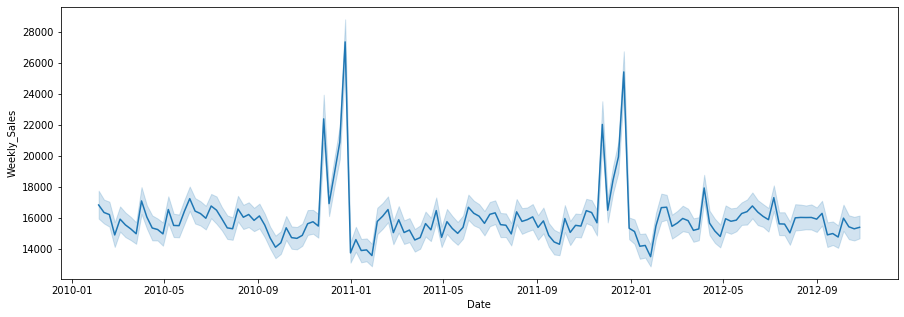

In [22]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=df.index, y="Weekly_Sales", data=df)

The large Thanksgiving and Christmas sales increases are easily seen above. To check how much exactly those events differ from the usual sales, I used the box plot and distance plot for a single shop:

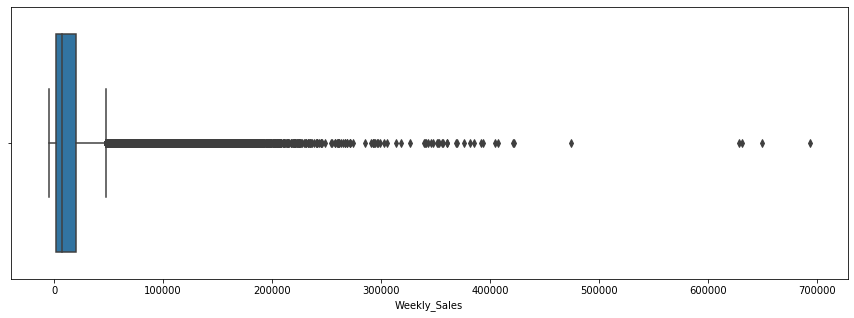

In [23]:
plt.figure(figsize=(15, 5))
sns.boxplot(x="Weekly_Sales", data=df)

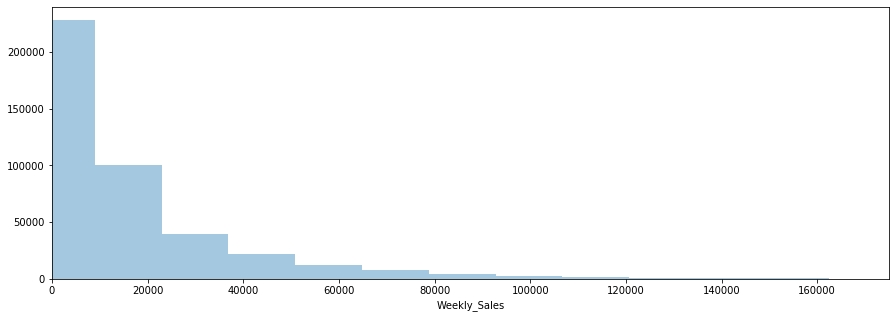

In [24]:
plt.figure(figsize=(15, 5))
plt.xlim(0, 175000)
sns.distplot(df["Weekly_Sales"], kde=False)

Holidays are definite outliers (in terms of the dependent variable `Weekly_Sales`). While typical sales are around 10000, those special occasions are often 100k or more. This will have large impact on many regression algorithms that don't extrapolate the values well, e.g. decision trees ensembles.

Checking the numerical variables distributions through box plots:

Temperature        AxesSubplot(0.125,0.657941;0.133621x0.222059)
Fuel_Price      AxesSubplot(0.285345,0.657941;0.133621x0.222059)
CPI              AxesSubplot(0.44569,0.657941;0.133621x0.222059)
Unemployment    AxesSubplot(0.606034,0.657941;0.133621x0.222059)
Size            AxesSubplot(0.766379,0.657941;0.133621x0.222059)
dtype: object

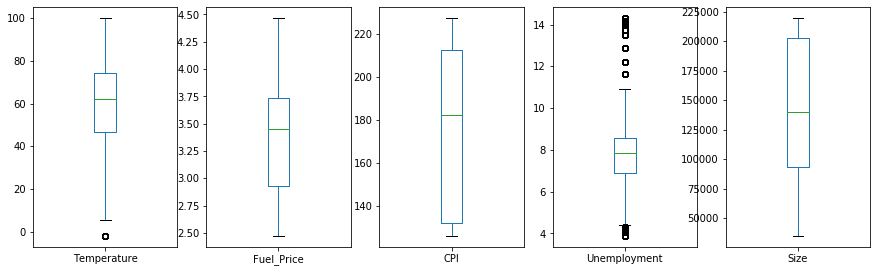

In [25]:
features = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "Size"]
df[features].plot(kind="box", subplots=1, layout=(3,5), figsize=(15, 15))

`Temperature`, `Fuel_Price`, `CPI` and `Size` features have approximately normal distributions based on the box plots.

The `Unemployment` feature has many outliers, but it can just have heavy tails; to check this, I've plotted it on a line plot.

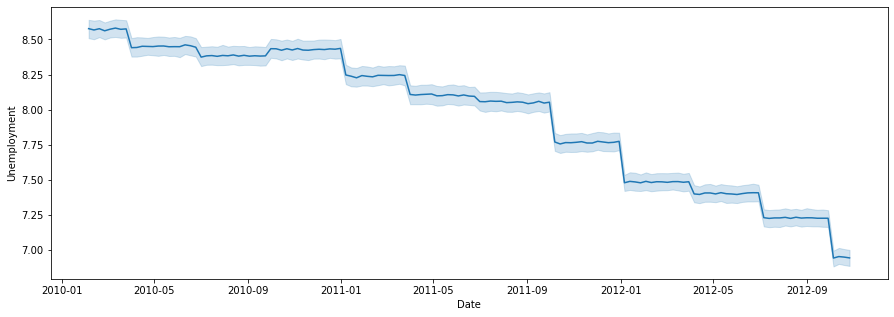

In [26]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=df.index, y="Unemployment", data=df)

It seems like the unemployment just decreases steadily over time, showing no other trend over time. There are no particular changes around holidays. This feature may be just a sign of Walmart expanding and hiring more employees. Check whether there is a correlation between unemployment and weekly sales at all:

In [27]:
df[["Unemployment", "Weekly_Sales"]].corr()

,Unemployment,Weekly_Sales
Unemployment,1.000000,-0.025864
Weekly_Sales,-0.025864,1.000000


Since there seems to be no correlation (logical, visual and mathematical) between unemployment and the target variable, I decided to drop it and save the result in a separate dataframe for checking models results on both of them.

In [28]:
df_no_unemployment = df.drop("Unemployment", axis=1)

Features correlations show no significantly correlated features:

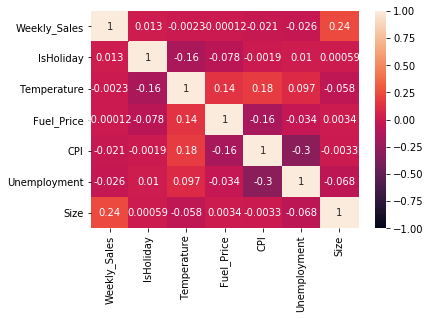

In [29]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

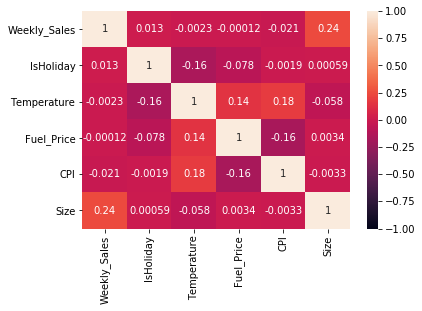

In [30]:
sns.heatmap(df_no_unemployment.corr(), vmin=-1, vmax=1, annot=True)

## Forecasting models

## Data preparation

Separate data and target:

In [70]:
y = df["Weekly_Sales"]
X = df.drop("Weekly_Sales", axis=1)

Use one-hot encoding for categorical features:

In [71]:
X = pd.get_dummies(X)

Reset index, since most libraries do not work with time series dataframes:

In [72]:
X.reset_index(inplace=True)

Create an additional copy of the data without the `Date` column, since most libraries will not work with datetime data type and for simple models it will be sufficient:

In [73]:
X_nontemp = X.iloc[:, 1:]  # non-temporal version

Compare both types of data:

In [76]:
X.head()

,Date,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Store_1,Store_2,Store_3,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
0,2010-02-05,False,42.31,2.572,211.096358,8.106,151315,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2010-02-12,True,38.51,2.548,211.242170,8.106,151315,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2010-02-19,False,39.93,2.514,211.289143,8.106,151315,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2010-02-26,False,46.63,2.561,211.319643,8.106,151315,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2010-03-05,False,46.50,2.625,211.350143,8.106,151315,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [77]:
X_nontemp.head()

,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Store_1,Store_2,Store_3,Store_4,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
0,False,42.31,2.572,211.096358,8.106,151315,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,True,38.51,2.548,211.242170,8.106,151315,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,False,39.93,2.514,211.289143,8.106,151315,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,False,46.63,2.561,211.319643,8.106,151315,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,False,46.50,2.625,211.350143,8.106,151315,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


For basic, non-temporal models, simple train-test split will be used for validation:

In [81]:
X_nontemp_train, X_nontemp_val, y_train, y_val = train_test_split(X_nontemp, y, test_size=0.2)

## Linear regression baseline

Simple linear regression with L2 regularization will be my basic baseline model:

In [79]:
lin_reg = LinearRegression()
lin_reg.fit(X_nontemp_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [84]:
y_pred = lin_reg.predict(X_nontemp_val)

In [85]:
rmse = mean_squared_error(y_val, y_pred, squared=False)
print("Linear regression RMSE:", rmse)

Linear regression RMSE: 13299.994320829577


## XGBoost

XGBoost regression with built-in L1 and L2 regularization:

In [86]:
xgb_reg = XGBRegressor()
xgb_reg.fit(X_nontemp_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [87]:
y_pred = xgb_reg.predict(X_nontemp_val)

In [88]:
rmse = mean_squared_error(y_val, y_pred, squared=False)
print("XGBoost RMSE:", rmse)

XGBoost RMSE: 6951.304042221916
